### VRO telescope parameters

#### Obscuration (inner_radius / outer_radius of M1M3)
obscuration: 0.61

#### Focal length in m
focalLength: 10.312

#### Aperture diameter in m
apertureDiameter: 8.36

#### Defocal distance offset in m
offset:
-  0.5mm: 0.5e-3
-  1.0mm: 1.0e-3
-  1.5mm: 1.5e-3
-  2.0mm: 2.0e-3
-  2.5mm: 2.50e-3

#### Camera pixel size in m
pixelSize: 10.0e-6

#### Notebook to use ts_wep to create example donuts as a function of distance from the focal plane

From Bo Xin's write up

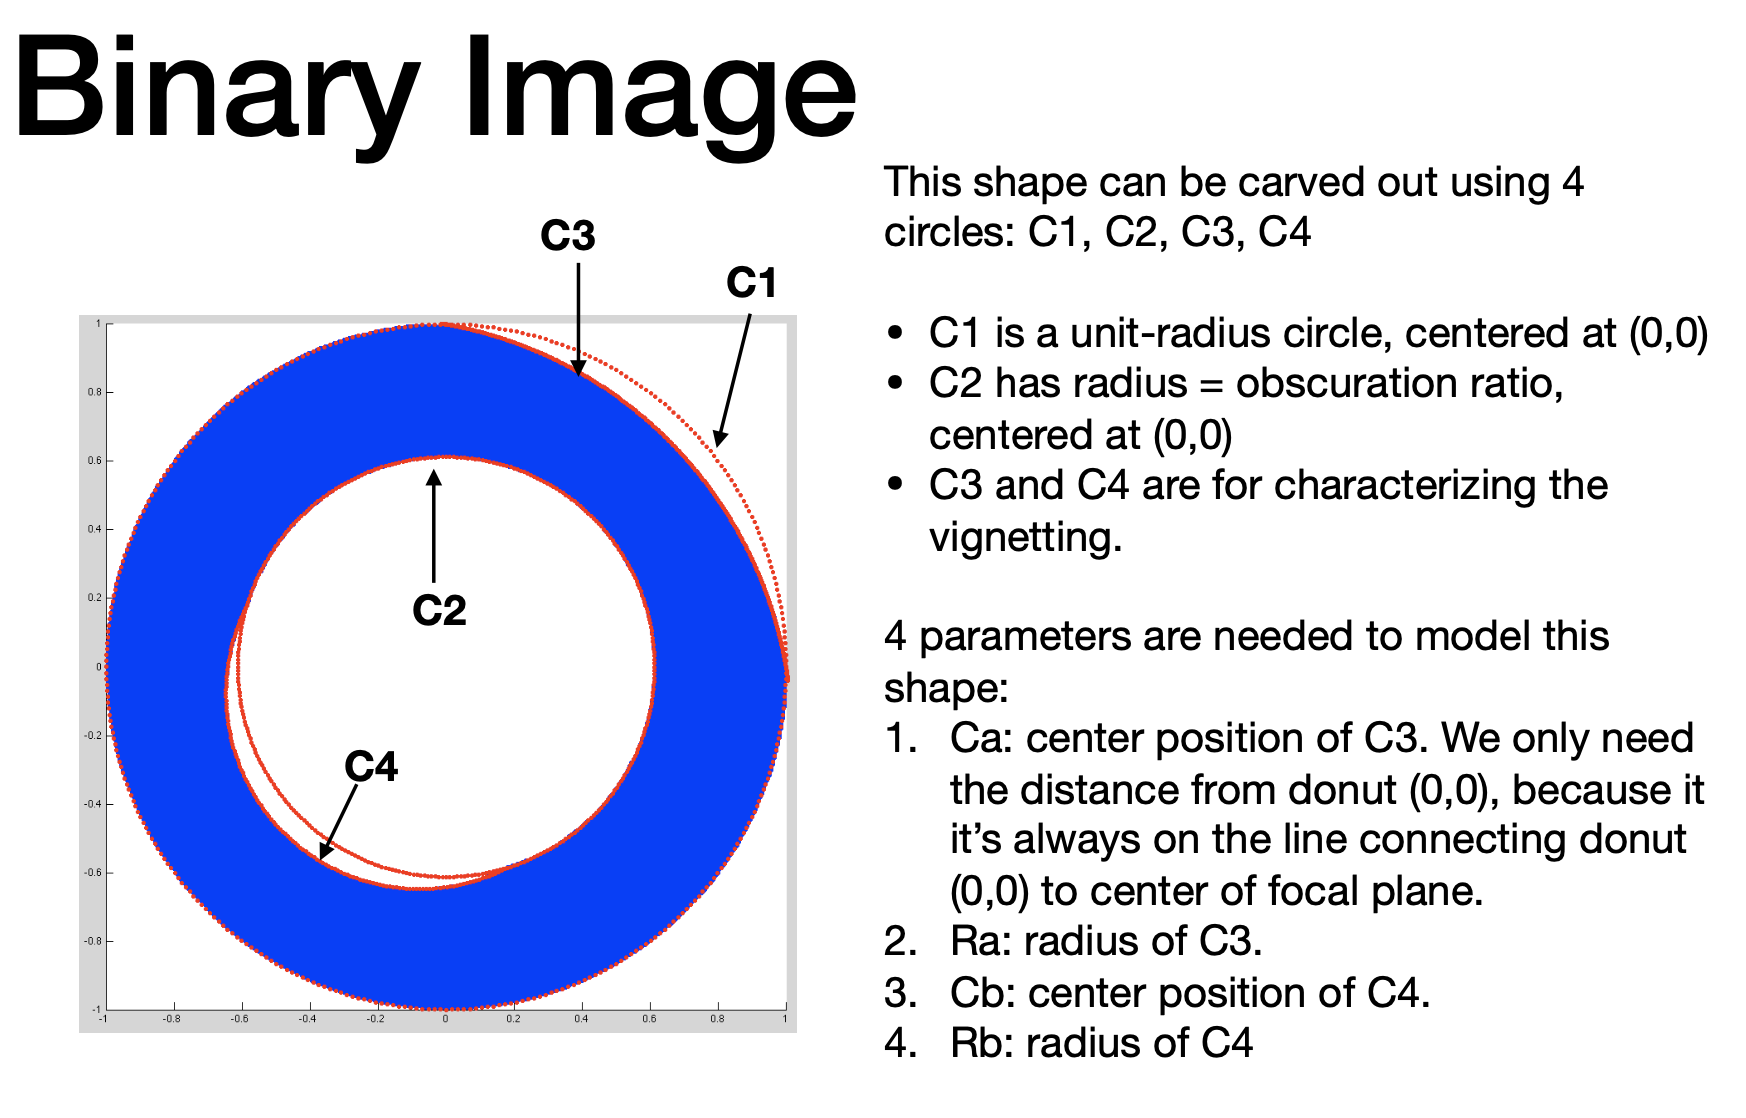

Simulate donut shape across the WFS to see how it varies and how centroiding is sensitive to the kernel. Can we assume a single corrleation (~PSF) kernel for the whole WFS


In [13]:
import os
import numpy as np
from lsst.ts.wep.cwfs.Image import Image
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import getModulePath, getConfigDir, CamType
from matplotlib import pyplot as plt

%matplotlib inline

In [32]:
# Load Instrument parameters
instDir = os.path.join(getConfigDir(), "cwfs", "instData")
dimOfDonutOnSensor = 256
inst = Instrument(instDir)
inst.config(CamType.LsstCam, dimOfDonutOnSensor)

In [33]:
#create image for mask
img = CompensableImage()

### Create and display a single donut

In [34]:
#define postion of dounut in degrees relative to center of field
boundaryT = 0
maskScalingFactorLocal=1
img.fieldX=1.25
img.fieldY=1.15
img.makeMask(inst, "offAxis", boundaryT, maskScalingFactorLocal)

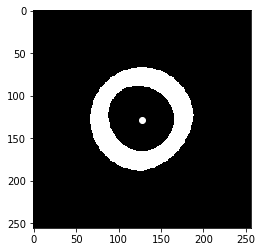

In [35]:
#display image with point indicating the center
plt.imshow(img.cMask, cmap='gray')
plt.scatter(128.,128., c='w')
plt.show()

### Plot array of donuts as a function of distance from center of field: offset in x only

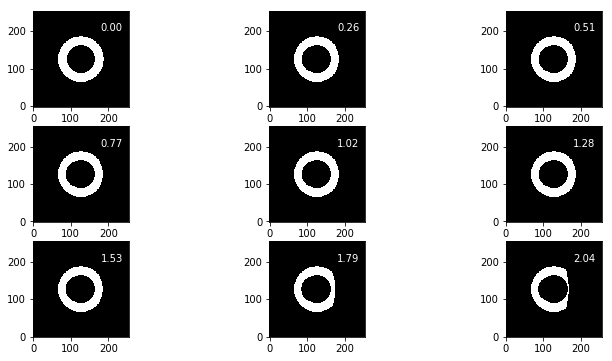

In [36]:
#plot array of images as a function of distance
nimages = 9
images_per_row = 3
min_distance = 0
max_distance = 2.3
distance_step = (max_distance - min_distance)/nimages

fig = plt.figure(figsize=(12,6))
imgList=[]
for i in np.arange(nimages):
    img = CompensableImage()
    sub = fig.add_subplot(int(nimages/images_per_row), images_per_row, i + 1)
    img.fieldX = min_distance + distance_step*i
    img.fieldY = 0.
    dist = np.sqrt(img.fieldX**2 + img.fieldY**2)
    img.makeMask(inst, "offAxis", boundaryT, maskScalingFactorLocal)
    imgList.append(img)
    sub.imshow(img.cMask, cmap='gray', origin='lower')
    sub.text(180, 200, "{:.2f}".format(dist), color='w')
plt.show()

### Fast convolution/correlation for image and kernel

In [37]:
#convolution/correlation code for centroids
from lsst.afw.image import Image, Mask, MaskedImage, ImageF, MaskedImageF, ExposureF
from numpy.fft import fft2, ifft2
from scipy.signal import fftconvolve, correlate2d

def convolveExposureWithImage(exposure, kernelImage):
    '''Convolve image and variance planes in an exposure with an image using FFT
        Does not convolve mask. Returns new exposure'''
    
    newExposure = exposure.clone() 

    image = convolveImageWithImage(newExposure.getImage(), kernelImage)
    variance = convolveImageWithImage(newExposure.getVariance(), kernelImage)
    
    newExposure.image = image
    newExposure.variance = variance
    return newExposure

def convolveImageWithImage(image, kernelImage, conv=True, fft=True):
    '''Convolve/correlate an image with a kernel
        Option to use an FFT or direct (slow)
        Returns an image'''
    if conv:
        array = fftconvolve(image.getArray(), kernelImage.getArray(), mode='same')
    else:
        if fft:
            array = np.roll(ifft2(fft2(kernelImage.getArray()).conj()*fft2(image.getArray())).real, 
                         (image.getArray().shape[0] - 1)//2, axis=(0,1))
        else:
            array = correlate2d(image.getArray(), kernelImage.getArray(), mode='same')
    newImage = ImageF(array.shape[0], array.shape[1])
    newImage.array[:] = array
    return newImage

### Setup source detection and measurements using LSST stack

In [38]:
#configure sources detections and measurements
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection import SourceDetectionTask

import lsst.afw.detection as afwDetection
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig
import lsst.afw.image as afwImage

# define detection parameters (set for correlated image)
# TODO check if should normalize kernel
schema = afwTable.SourceTable.makeMinimalSchema()
detectConfig = SourceDetectionTask.ConfigClass()
detectConfig.thresholdValue = 4000.   # detection threshold in units of thresholdType
#detectConfig.thresholdValue = 0.5   # detection threshold in units of thresholdType
detectConfig.thresholdType = "value"#"stdev"   # units for thresholdValue
detectConfig.minPixels = 5   # also worth playing around with
sourceDetectionTask = SourceDetectionTask(config=detectConfig)


# define characterization parameters
charConfig = CharacterizeImageConfig()
charConfig.installSimplePsf.fwhm = .05 #was .05 #this set the fwhm of the simple PSF to that of optics
charConfig.doMeasurePsf = False
charConfig.doApCorr = False 
charConfig.repair.doCosmicRay = False  
charConfig.detection.background.binSize = 10   # worth playing around with
#charConfig.background.binSize = 50
charConfig.detection.minPixels = 5   # also worth playing around with
charTask = CharacterizeImageTask(config=charConfig)

calConfig = CalibrateConfig()
calConfig.doAstrometry = False
calConfig.doPhotoCal = False
calConfig.doApCorr = False
calConfig.doDeblend = False   # these are well-separated objects
# these images should have a uniform background, so measure it on scales which are larger than the objects
calConfig.detection.background.binSize = 50
calConfig.detection.minPixels = 5

### Compare the effect of correlating (correct) and convolving an image with the PSF kernel

We need to correlate as the PSF/donut is not symmetric

Text(0.5, 1.0, 'Correlated Image (direct/slow)')

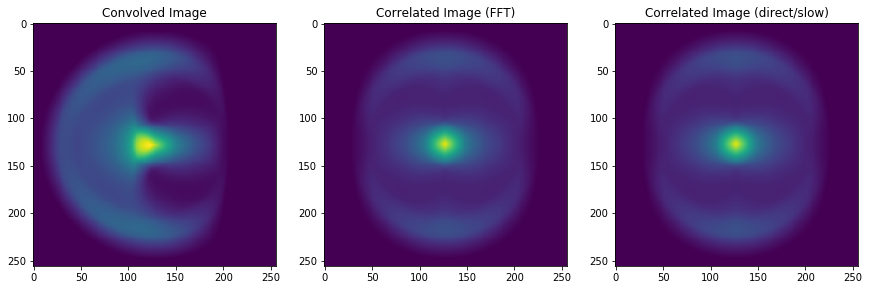

In [40]:
# Compare correaltion with convolution
fig = plt.figure(figsize=(20,5))
newImage = ImageF(imgList[8].cMask.astype('float32'))
cimCon = convolveImageWithImage(newImage, newImage, conv=True)
cimCor = convolveImageWithImage(newImage, newImage, conv=False, fft=True)
cimCorSlow = convolveImageWithImage(newImage, newImage, conv=False, fft=False)

fig.add_subplot(1, 4, 1)
plt.imshow(cimCon.getArray())
plt.title('Convolved Image')
fig.add_subplot(1, 4, 2)
plt.imshow(cimCor.getArray())
plt.title('Correlated Image (FFT)')
fig.add_subplot(1, 4, 3)
plt.imshow(cimCorSlow.getArray())
plt.title('Correlated Image (direct/slow)' )


### Display correlated image as an expsoure

In [41]:
exp = ExposureF(cimCor.getHeight(),cimCor.getWidth())
exp.setImage(cimCor)

5410.0

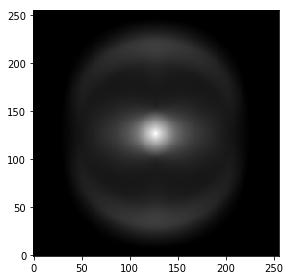

In [42]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 
afw_display = afwDisplay.Display()
afw_display.mtv(exp.image)
(exp.image.getArray()).max()

### Run source detection and centroiding. 

Use the base_NaiveCentroid_x and  base_NaiveCentroid_y and compare to the expected centroid position

Plot the correlated image and the base_NaiveCentroid centroid, the center of the image, and the peak flux position

(42.548678324522186, 213.4513216754778, 76.8, 179.2)

<Figure size 432x288 with 0 Axes>

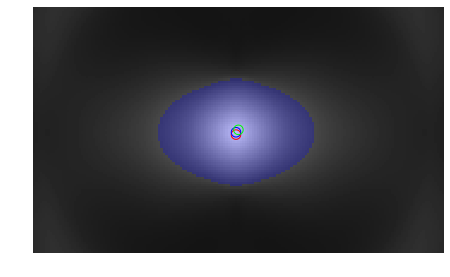

In [46]:
#calculate footprints - this step is not needed as we can run the source detection task
footprint_set = sourceDetectionTask.detectFootprints(exp, sigma=1.)
f_set_pos = footprint_set.positive
f_prints = f_set_pos.getFootprints()
source_centroids = [fpf.getCentroid() for fpf in f_prints]
#print (source_centroids[0][0],source_centroids[0][1])

charResult = charTask.run(exp)  
calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)
calResult = calTask.run(charResult.exposure, background=charResult.background, 
                        icSourceCat = charResult.sourceCat)

xcen = calResult.sourceCat['base_NaiveCentroid_x']
ycen = calResult.sourceCat['base_NaiveCentroid_y']
#print (xcen, ycen)

plt.figure()
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 
afw_display = afwDisplay.Display()
afw_display.mtv(exp)
afw_display.zoom(5)
#centroid
afw_display.dot('o', xcen, ycen, size=2, ctype='red')
#peak flux
afw_display.dot('o', source_centroids[0][0], source_centroids[0][1], size=2, ctype='blue')
#center of image
afw_display.dot('o', 128, 128, size=2, ctype='green')

plt.gca().axis('off')

### Measure the impact on centroiding on using the wrong donut as a matched filter

Loop over the array of donuts (from the center to the end of the field) and use each donut as a matched filter
Measure the centroid from the correlation with each donut and determine how sensitive the centroiding is (in pixels) 
compared to the true centroid of the image

In [50]:
xoffsets = np.zeros((len(imgList), len(imgList)))
yoffsets = np.zeros((len(imgList), len(imgList)))

for i,img1 in enumerate(imgList):
    for j,img2 in enumerate(imgList):
        #create images, correlate image, 
        newImage1 = ImageF(img1.cMask.astype('float32'))
        newImage2 = ImageF(img2.cMask.astype('float32'))
        convolvedImage = convolveImageWithImage(newImage1, newImage2, conv=False, fft=True)
        
        #create an exposure and measure centroid
        convolvedExp = afwImage.ExposureF(convolvedImage.getHeight(), 
                                          convolvedImage.getWidth())
        convolvedExp.setImage(convolvedImage)

        charResult = charTask.run(convolvedExp)  
        calTask = CalibrateTask(config=calConfig, icSourceSchema=charResult.sourceCat.schema)
        calResult = calTask.run(charResult.exposure, background=charResult.background, 
                        icSourceCat = charResult.sourceCat)
        
        xcen = calResult.sourceCat['base_SdssCentroid_x']
        ycen = calResult.sourceCat['base_SdssCentroid_y']
        xoffsets[i,j] = xcen - newImage1.getWidth()/2. +0.5
        yoffsets[i,j] = ycen - newImage1.getHeight()/2. +0.5

Print centroid offsets in x and y Note that the shift in donut position is only in x so we expect all distortions  

In [51]:
np.set_printoptions(precision=3, suppress=True)
print(xoffsets)

[[-0.508  0.627  0.627  0.627  0.627  0.627  0.643  1.976  2.064]
 [-1.555 -0.466 -0.466 -0.466 -0.466 -0.466 -0.442  1.092  1.2  ]
 [-1.555 -0.466 -0.466 -0.466 -0.466 -0.466 -0.442  1.092  1.2  ]
 [-1.555 -0.466 -0.466 -0.466 -0.466 -0.466 -0.442  1.092  1.2  ]
 [-1.555 -0.466 -0.466 -0.466 -0.466 -0.466 -0.442  1.092  1.2  ]
 [-1.555 -0.466 -0.466 -0.466 -0.466 -0.466 -0.442  1.092  1.2  ]
 [-1.573 -0.49  -0.49  -0.49  -0.49  -0.49  -0.465  1.072  1.17 ]
 [-7.61  -5.117 -5.117 -5.117 -5.117 -5.117 -4.806 -0.353  0.952]
 [-9.592 -6.178 -6.178 -6.178 -6.178 -6.178 -6.084 -3.969 -0.318]]


In [52]:
print(yoffsets)

[[-0.508 -0.512 -0.512 -0.512 -0.512 -0.512 -0.514 -0.527 -0.562]
 [-0.515 -0.517 -0.517 -0.517 -0.517 -0.517 -0.519 -0.529 -0.568]
 [-0.515 -0.517 -0.517 -0.517 -0.517 -0.517 -0.519 -0.529 -0.568]
 [-0.515 -0.517 -0.517 -0.517 -0.517 -0.517 -0.519 -0.529 -0.568]
 [-0.515 -0.517 -0.517 -0.517 -0.517 -0.517 -0.519 -0.529 -0.568]
 [-0.515 -0.517 -0.517 -0.517 -0.517 -0.517 -0.519 -0.529 -0.568]
 [-0.516 -0.519 -0.519 -0.519 -0.519 -0.519 -0.52  -0.53  -0.569]
 [-0.153 -0.531 -0.531 -0.531 -0.531 -0.531 -0.533 -0.534 -0.559]
 [-0.146 -0.142 -0.142 -0.142 -0.142 -0.142 -0.143 -0.135 -0.567]]
